# VQE on LiH Molecule

Considering actual qubits transitioning from |0> state to |1> state based on the anharmonicity of qubits energy levels we can measure the transitioning frequency which corresponds to the actual ground state energy.

### Steps taken to make the quantum operators and quantum circuits ready for the VQE to run its algorithm:



> 1.  Setting up the driver
> 2.  Extracting the hamiltonions and converting it to qubit operators using specific methods to reduce number of qubits used
>3.  Initialising states of the statevector using HacktreeFock method 
>4. Implementing the diagonalizor method to get the exact ground level energy value calculated using Hamiltonion operator
>5. Making of ansatz and choosing the optimizer 
>6. Getting statevector_simulator backend for VQE
>7. Implementing Variational Quantum Eigensolver (VQE)
>8. Tabulating all the trials made 

**All the necessary imports are done for each cell implementation.**


## **Setting up the driver**
Used PySCFDriver to extract all the data about the molecule given.

In [1]:
from qiskit_nature.drivers import PySCFDriver

driver =[]
molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
driver = PySCFDriver(atom=molecule)
qmolecule = driver.run()
#qmolecule

## Extracting the hamiltonions and using specific reduction methods
Used FreezeCoreTransformer() and removed 3rd and 4th orbital mapped on the problem variable. Further used the hamiltonion fermionic operator to convert it into QubitOperator using ParityMapper(), reducing of 2 qubits and applying z2symmetry reduction on the remaining orbitals.

**Now choosing of 3rd and 4th orbitals, were purely on the basis of trail and error method comparing the exact energy given by those configurations with the actual energy.** 

After converting the hamiltonion to QuantumOperator, number of particles reduced to 2, number of molecular orbitals choosen reduced to 4 (which earlier was 6) and number of qubits used was 4.

**Note - This is the cell which is responsible for the reduction of qubits been used for our purpose as well as giving decent value of exact energy using the diagonalizor**

In [2]:
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit.aqua.operators import Z2Symmetries

tr = FreezeCoreTransformer(True,[3,4])
problem = ElectronicStructureProblem(driver,[tr])
second_q_ops = problem.second_q_ops()
H_op = second_q_ops[0] 

converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True, z2symmetry_reduction=[1,1])
num_particles = (problem.molecule_data_transformed.num_alpha,
             problem.molecule_data_transformed.num_beta)
qubit_op = converter.convert(H_op, num_particles=num_particles)
print(num_particles)
print(problem.molecule_data_transformed.num_molecular_orbitals)
print(qubit_op.num_qubits)

(1, 1)
3
4


## Initialising states of the statevector using HacktreeFock method
This chooses a proper initial statevector depending on the number of qubits, QuantumOperators and number of spin orbitals 

In [3]:
from qiskit_nature.circuit.library import HartreeFock

num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals
init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
print(init_state)

     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          


## Implementing the diagonalizor method to get the exact ground level energy value calculated using Hamiltonion operator
Here we make a function exact_diagonalizer() which uses the hamiltonion operator and further extracts the ground energy value using GroundStateEigensolver(converter, solver)

In [4]:
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
import numpy as np 

def exact_diagonalizer(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

result_exact = exact_diagonalizer(problem, converter)
exact_energy = np.real(result_exact.eigenenergies[0])
print("Exact electronic energy", exact_energy)
print(result_exact)

# The targeted electronic energy for H2 is -1.85336 Ha
# Check with your VQE result.

Exact electronic energy -1.0887060157347397
=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


## Making of ansatz and choosing the optimizer
This is where the ansatz or the quantum circuit is choosen to be optimized by choosing your own optimizer.

Here I choosed TwoLocal ansatz as compared to all other ansatz available, it is the most simplest ansatz with very very few number of CX gates. Our main motive is to reduce the computational cost as well as getting a decent amount of accuracy and so keeping this in mind, for the configuration of 3,4 orbitals removal as well as z2symmetry I came to the result after numerous iterations that, parameters for TwoLocal with linear entanglement hving RX, RY and CX gates and repeated only onces with RY and RZ gates filling the final layer gives a decent accuracy in resulting energy value with just cost of 3, only 3 CX gates used.

Also it was noticed that for VQE to successfully reach to the exact energy value, all qubits used must be entangled(CX) with each other atleast and so as this configuration uses 4 qubits, hence I could reduce my cost to just 3. For further reduction in cost, the number of qubits itself has to decrease to 3 or maybe 2, but then it might be so simplified that now it may have lost the core properties of the molecule which could have significantly helped calculating the energy.

In [5]:
from qiskit.circuit.library import TwoLocal
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, SLSQP
from qiskit.circuit import Parameter, QuantumCircuit, QuantumRegister

ansatz = TwoLocal(qubit_op.num_qubits, ['rz','ry'],['cx'], reps=1, 
                      entanglement='linear', skip_final_rotation_layer=False)


#Custom Ansatz (choosing our own gates to be applied in our custom sequence) 
#theta = Parameter('a')
#n = qubit_op.num_qubits
#qc = QuantumCircuit(qubit_op.num_qubits)
#qc.h(range(n))
#qc.rz(theta, range(n))
#qc.ry(theta, range(n))
#qc.cx(0,1)
#qc.cx(1,2)
#qc.h(range(n))
#ansatz = qc

ansatz.compose(init_state, front=True, inplace=True)

optimizer = COBYLA(maxiter=16000)

print(ansatz)

        ┌───┐    ┌──────────┐┌──────────┐     ┌──────────┐┌───────────┐»
q_0: ───┤ X ├────┤ RZ(θ[0]) ├┤ RY(θ[4]) ├──■──┤ RZ(θ[8]) ├┤ RY(θ[12]) ├»
        ├───┤    ├──────────┤├──────────┤┌─┴─┐└──────────┘└┬──────────┤»
q_1: ───┤ X ├────┤ RZ(θ[1]) ├┤ RY(θ[5]) ├┤ X ├─────■───────┤ RZ(θ[9]) ├»
     ┌──┴───┴───┐├──────────┤└──────────┘└───┘   ┌─┴─┐     └──────────┘»
q_2: ┤ RZ(θ[2]) ├┤ RY(θ[6]) ├────────────────────┤ X ├──────────■──────»
     ├──────────┤├──────────┤                    └───┘        ┌─┴─┐    »
q_3: ┤ RZ(θ[3]) ├┤ RY(θ[7]) ├─────────────────────────────────┤ X ├────»
     └──────────┘└──────────┘                                 └───┘    »
«                               
«q_0: ──────────────────────────
«     ┌───────────┐             
«q_1: ┤ RY(θ[13]) ├─────────────
«     ├───────────┤┌───────────┐
«q_2: ┤ RZ(θ[10]) ├┤ RY(θ[14]) ├
«     ├───────────┤├───────────┤
«q_3: ┤ RZ(θ[11]) ├┤ RY(θ[15]) ├
«     └───────────┘└───────────┘


## Getting statevector_simulator backend for VQE

In [6]:
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')

## Implementing Variational Quantum Eigensolver (VQE)

Finally run the VQE also simultaneously calling the callback function giving us the key informations as the algorithm progresses.

We start with an initial value for each parameters residing in the ansatz which are tuned by the VQE to get nearer to the value.

In [7]:
from qiskit.algorithms import VQE

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

counts = []
values = []
params = []
deviation = []

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

algorithm = VQE(ansatz,
                optimizer=optimizer,
                quantum_instance=backend,
                callback=callback,
                initial_point=initial_point)

result = algorithm.compute_minimum_eigenvalue(qubit_op)

print(result)

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 16000,
    'eigenstate': array([-2.95831307e-05-1.22252999e-05j, -1.00364062e-03-3.92522104e-03j,
        5.10687801e-03+1.99713870e-02j, -2.45883330e-01-9.61763525e-01j,
       -5.15924667e-03-1.14348734e-02j, -1.47212488e-05-1.60338085e-05j,
       -2.32657490e-05-1.26096695e-04j,  2.13403681e-03+8.31987401e-03j,
        2.60264374e-04+9.73904519e-04j, -7.00282737e-05+1.03498048e-05j,
        3.61388236e-04-3.49295033e-05j, -1.74544686e-02+1.48993373e-03j,
        2.99087923e-02+1.12590976e-01j,  1.39132627e-04+4.93417562e-04j,
       -1.23860642e-04-4.58902822e-04j,  8.64719166e-05-2.91689139e-05j]),
    'eigenvalue': -1.084975542519339,
    'optimal_parameters': {   ParameterVectorElement(θ[8]): 0.003946838106672179,
                              ParameterVectorElement(θ[9]): 1.0955765827396178,
                              ParameterVectorElement(θ[7]): -0.10866910463259569,
                              ParameterVec

## Tabulating all the trials made
Finally save all the required results with ansatz parameters and optimizers used and plot a graph showing the progress of the VQE on reaching the exact ground level energy value with an error as small as 0.004 units. 

**This is one of the important cells as it made a track of what went wrong with different combinations of parameters and also kept track of the currrent best combination of ansatz and optimizer used in terms of least CX gates used and accurate enough. The graph also helped in realizing how robust is the optimizer in optimizing the ansatz.**  

,optimizer,ansatz,# of qubits,# of parameters,rotation blocks,entanglement_blocks,entanglement,repetitions,error (mHa),pass,score
0,COBYLA,TwoLocal,4,16,"[ry, rz]",cx,linear,1,3.730473,True,3


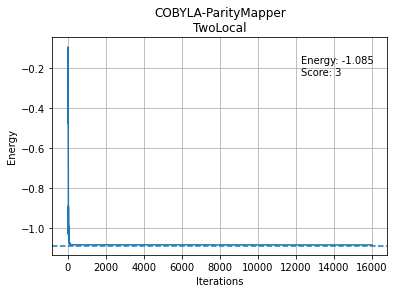

In [8]:
# Store results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

# Unroller transpile your circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
ansatz_type = "TwoLocal" #added by me
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

if ansatz_type == "TwoLocal":
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': ['ry','rz'],
        'entanglement_blocks': 'cx',
        'entanglement': 'linear',
        'repetitions': 1,
        'skip_final_rotation_layer': False,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}
else:
    result_dict = {
        'optimizer': optimizer.__class__.__name__,
        'mapping': converter.mapper.__class__.__name__,
        'ansatz': ansatz.__class__.__name__,
        'rotation blocks': None,
        'entanglement_blocks': None,
        'entanglement': None,
        'repetitions': None,
        'skip_final_rotation_layer': None,
        'energy (Ha)': energy,
        'error (mHa)': (energy-exact_energy)*1000,
        'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
        '# of parameters': len(result.optimal_point),
        'final parameters': result.optimal_point,
        '# of evaluations': result.optimizer_evals,
        'optimizer time': result.optimizer_time,
        '# of qubits': int(qubit_op.num_qubits),
        '# of CNOTs': cnots,
        'score': score}

# Plot the results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iterations')
ax.set_ylabel('Energy')
ax.grid()
fig.text(0.7, 0.75, f'Energy: {result.optimal_value:.3f}\nScore: {score:.0f}')
plt.title(f"{result_dict['optimizer']}-{result_dict['mapping']}\n{result_dict['ansatz']}")
ax.plot(counts, values)
ax.axhline(exact_energy, linestyle='--')
fig_title = f"\
{result_dict['optimizer']}-\
{result_dict['mapping']}-\
{result_dict['ansatz']}-\
Energy({result_dict['energy (Ha)']:.3f})-\
Score({result_dict['score']:.0f})\
.png"
fig.savefig(fig_title, dpi=300)

# Display and save the data
import pandas as pd
import os.path
filename = 'results_h2.csv'
if os.path.isfile(filename):
    result_df = pd.read_csv(filename)
    result_df = result_df.append([result_dict])
else:
    result_df = pd.DataFrame.from_dict([result_dict])
result_df.to_csv(filename)
result_df[['optimizer','ansatz', '# of qubits', '# of parameters','rotation blocks', 'entanglement_blocks',
    'entanglement', 'repetitions', 'error (mHa)', 'pass', 'score']]

Hence, after multiple trail and error as well as noting down the exact energy for each orbital removed I finally found that 3rd and 4th orbital removed together gives the exact energy very close or even lower than the actual energy(given by the grader). After finding out this configuration, I kept on tuning the TwoLocal parameters to get as low cost as possible without compromising with the accuracy.

My final solution uses 4 qubits having total of 16 parameters, chemical accuracy of 99.967% and final score was 3.  